# Example usage of the ofset free koopman MPC

In [1]:
import sys
import os
import numpy as np
#import pandas as pd
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

# Add 'src' to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

import models
import helper
%load_ext autoreload
%autoreload 2

Models imported succesfully
Helper imported succesfully


## Loading a Dataset

In [2]:
# Load experimental data from .mat files
from scipy.io import loadmat

# Path to experimental data
data_path = '../experimental_data/'

# Define experiment range (modular - easy to add more experiments)
experiment_start = 3
experiment_end = 9  # Change this to add more experiments

# Function to trim array from rear to be divisible by divisor
def trim_to_divisible(arr, divisor=80):
    """Trim array from the rear to make length divisible by divisor"""
    length = len(arr)
    remainder = length % divisor
    if remainder != 0:
        return arr[:length - remainder]
    return arr

# Option 4: Load experiments as SEPARATE sequences to avoid discontinuities
# Key insight: trim each experiment to be divisible by nsteps (80 after downsampling)
# so that when get_data reshapes into sequences, no sequence spans across experiments

nsteps_training = 80  # This must match nsteps used in model training
experiments = []

for exp_num in range(experiment_start, experiment_end + 1):
    # Load all variables for this experiment
    T1_data = loadmat(data_path + f'T1_ident_{exp_num}.mat')['T1']
    T2_data = loadmat(data_path + f'T2_ident_{exp_num}.mat')['T2']
    T4_data = loadmat(data_path + f'T4_ident_{exp_num}.mat')['T4']
    u1_data = loadmat(data_path + f'u1_ident_{exp_num}.mat')['u1'].reshape(-1, 1)
    u2_data = loadmat(data_path + f'u2_ident_{exp_num}.mat')['u2'].reshape(-1, 1)
    u3_data = loadmat(data_path + f'u3_ident_{exp_num}.mat')['u3'].reshape(-1, 1)
    
    # Trim each experiment to be divisible by (nsteps * 10) BEFORE downsampling
    # After downsampling by 10, it will be divisible by nsteps
    length = min(len(T1_data), len(u1_data))
    divisor = nsteps_training * 10  # 800 before downsampling becomes 80 after
    T1_data = trim_to_divisible(T1_data[:length], divisor=divisor)
    T2_data = trim_to_divisible(T2_data[:length], divisor=divisor)
    T4_data = trim_to_divisible(T4_data[:length], divisor=divisor)
    u1_data = trim_to_divisible(u1_data[:length], divisor=divisor)
    u2_data = trim_to_divisible(u2_data[:length], divisor=divisor)
    u3_data = trim_to_divisible(u3_data[:length], divisor=divisor)
    
    # Downsample (every 10th sample) - now guaranteed to be divisible by nsteps_training
    Y = np.concatenate([T1_data[::10], T2_data[::10], T4_data[::10]], axis=1)
    U = np.concatenate([u1_data[::10], u2_data[::10], u3_data[::10]], axis=1)
    
    # Verify divisibility
    assert len(Y) % nsteps_training == 0, f"Exp {exp_num}: length {len(Y)} not divisible by {nsteps_training}"
    
    experiments.append({'Y': Y, 'U': U, 'exp_num': exp_num})

# Split experiments into train and test
# Use experiments 3-7 for training, experiment 8 for testing
train_experiments = [exp for exp in experiments if exp['exp_num'] > 3]
test_experiments = [exp for exp in experiments if exp['exp_num'] <= 3]

# Stack experiments - this is now safe because:
# 1. Each experiment is divisible by nsteps_training
# 2. When get_data reshapes with shape (nbatch, nsteps, ny), sequences won't cross experiments
# 3. DataLoader shuffles complete sequences, preserving temporal continuity
train = {
    'Y': np.vstack([exp['Y'] for exp in train_experiments]),
    'U': np.vstack([exp['U'] for exp in train_experiments])
}

test = {
    'Y': np.vstack([exp['Y'] for exp in test_experiments]),
    'U': np.vstack([exp['U'] for exp in test_experiments])
}

# Keep individual experiments available if needed
train_list = [{'Y': exp['Y'], 'U': exp['U']} for exp in train_experiments]
test_list = [{'Y': exp['Y'], 'U': exp['U']} for exp in test_experiments]

print("Experimental data loaded successfully!")
print(f"Loaded experiments {experiment_start} to {experiment_end}")
print(f"Training experiments: {[exp['exp_num'] for exp in train_experiments]}")
print(f"Test experiments: {[exp['exp_num'] for exp in test_experiments]}")
print(f"Training samples (combined): {len(train['Y'])}")
print(f"Test samples (combined): {len(test['Y'])}")
print(f"Individual experiment lengths: {[len(exp['Y']) for exp in experiments]}")

# For backwards compatibility with existing code
T1_train = {'T1': train['Y'][:, :1]}
T2_train = {'T2': train['Y'][:, 1:2]}
T4_train = {'T4': train['Y'][:, 2:3]}
u1_train = {'u1': train['U'][:, :1]}
u2_train = {'u2': train['U'][:, 1:2]}
u3_train = {'u3': train['U'][:, 2:3]}

T1_test = {'T1': test['Y'][:, :1]}
T2_test = {'T2': test['Y'][:, 1:2]}
T4_test = {'T4': test['Y'][:, 2:3]}
u1_test = {'u1': test['U'][:, :1]}
u2_test = {'u2': test['U'][:, 1:2]}
u3_test = {'u3': test['U'][:, 2:3]}

Experimental data loaded successfully!
Loaded experiments 3 to 9
Training experiments: [4, 5, 6, 7, 8, 9]
Test experiments: [3]
Training samples (combined): 1440
Test samples (combined): 640
Individual experiment lengths: [640, 240, 240, 240, 240, 240, 240]


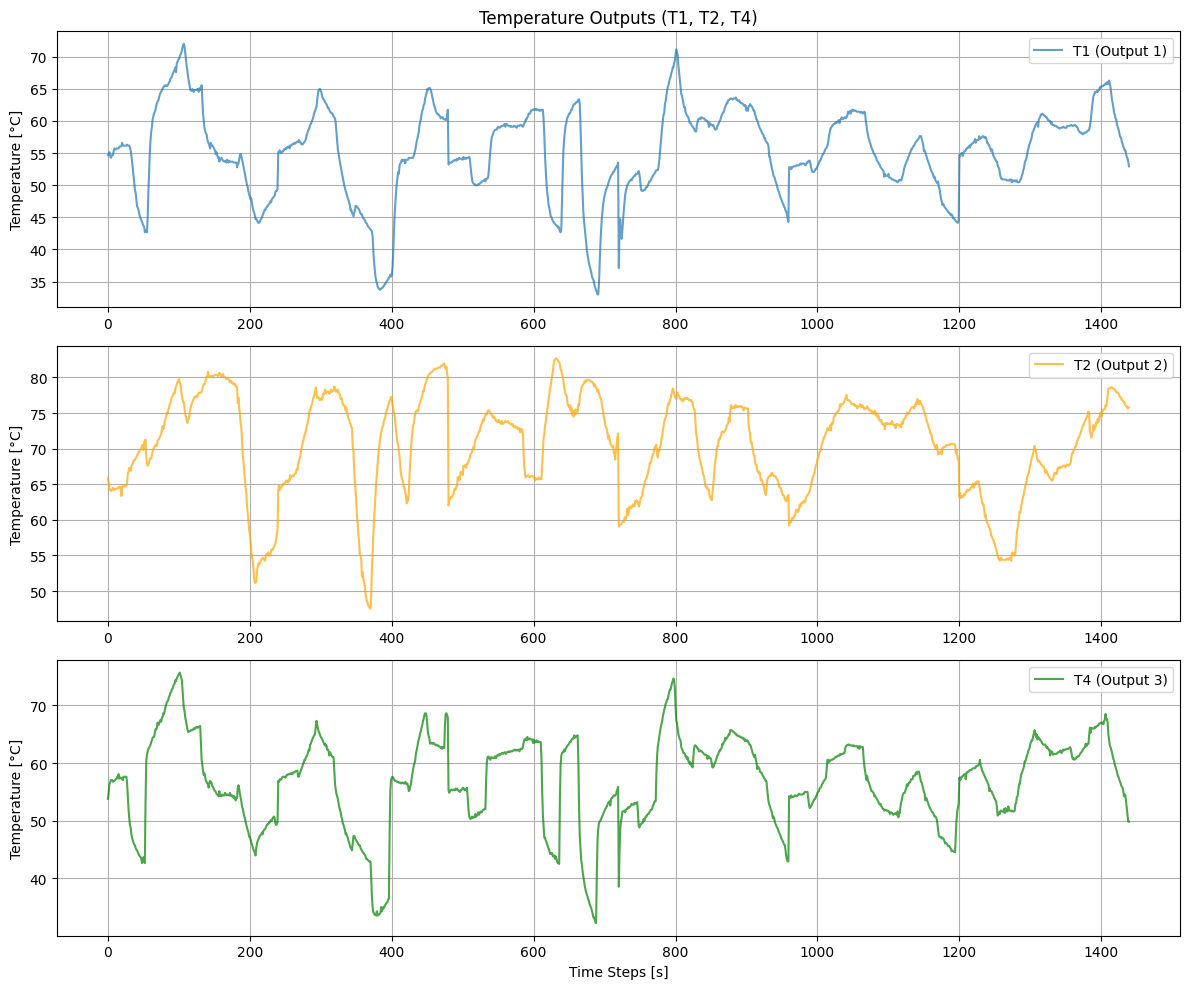

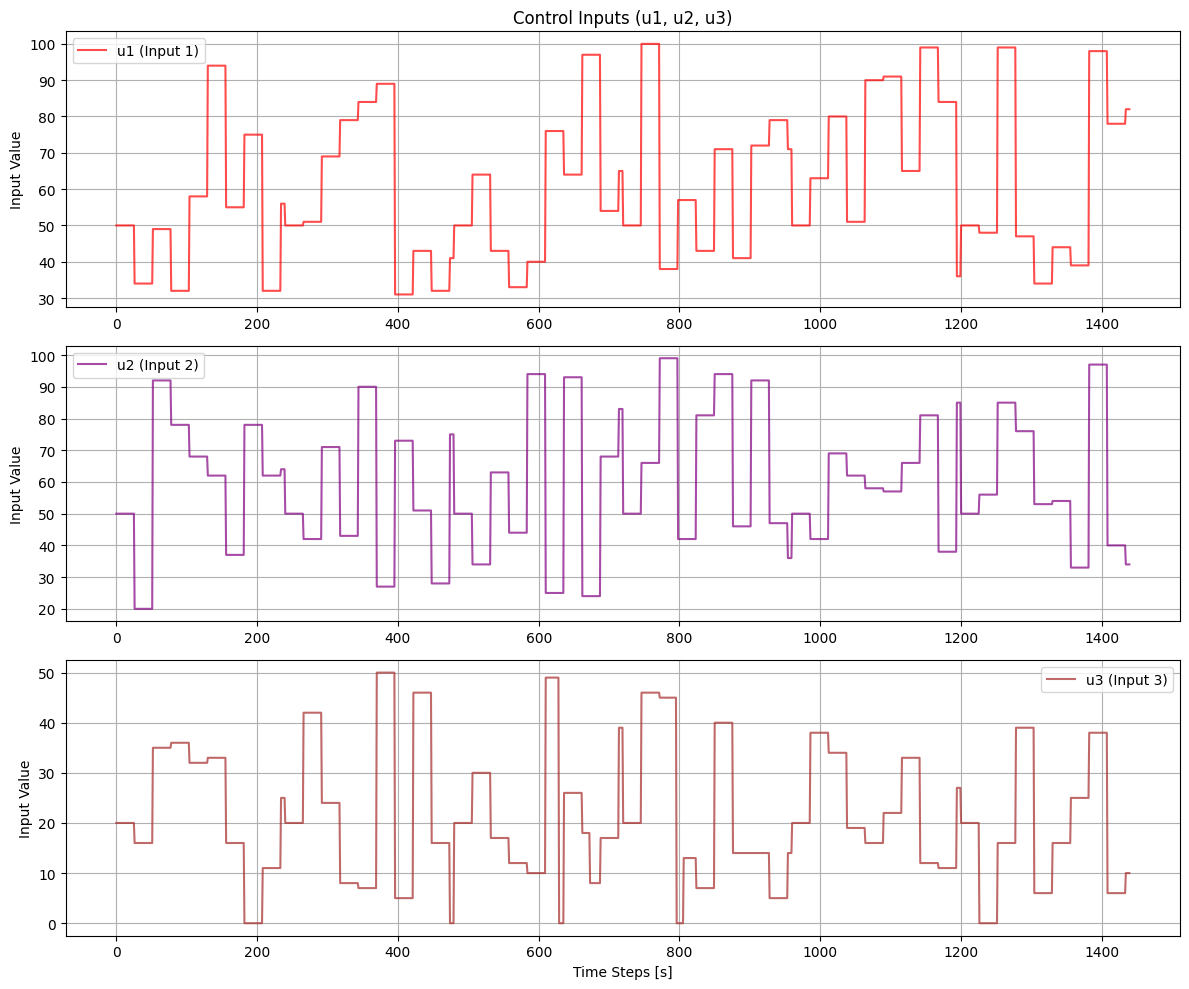

In [3]:
# Extract data from .mat dictionaries and prepare for plotting
# Outputs: T1, T2, T4
T1_data = T1_train['T1'].flatten()
T2_data = T2_train['T2'].flatten()
T4_data = T4_train['T4'].flatten()

# Inputs: u1, u2, u3
u1_data = u1_train['u1'].flatten()
u2_data = u2_train['u2'].flatten()
u3_data = u3_train['u3'].flatten()

# Determine the length to plot
part = min(3000, len(T1_data))

plt.figure(figsize=(12, 10))

# Plot outputs (T1, T2, T4)
plt.subplot(3, 1, 1)
plt.plot(T1_data[:part], label='T1 (Output 1)', alpha=0.7)
plt.title("Temperature Outputs (T1, T2, T4)")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(T2_data[:part], label='T2 (Output 2)', alpha=0.7, color='orange')
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(T4_data[:part], label='T4 (Output 3)', alpha=0.7, color='green')
plt.xlabel("Time Steps [s]")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot inputs (u1, u2, u3)
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(u1_data[:part], label='u1 (Input 1)', alpha=0.7, color='red')
plt.title("Control Inputs (u1, u2, u3)")
plt.ylabel("Input Value")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(u2_data[:part], label='u2 (Input 2)', alpha=0.7, color='purple')
plt.ylabel("Input Value")
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(u3_data[:part], label='u3 (Input 3)', alpha=0.7, color='brown')
plt.xlabel("Time Steps [s]")
plt.ylabel("Input Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Preparing data for training koopman models

In [4]:
def get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU):
    
    ny = train_sim['Y'].shape[1]
    nu = train_sim['U'].shape[1]
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, ny)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, ny)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    
    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(1, nbatch*nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(1, nbatch*nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data_forC = {'Y': trainX, 'Y0': trainX[:, 0:1, :],
                 'U': trainU}

    return train_loader, dev_loader, test_data, train_data_forC

In [5]:
nsteps = 80   # number of prediction horizon steps in the loss function
bs = 80      # minibatching batch size

In [6]:
# load scalers for scaling the data from saved files
scaler = joblib.load('../data/scaler.pkl')
scalerU = joblib.load('../data/scalerU.pkl')


In [7]:
train_loader, dev_loader, test_data, train_data = get_data(train, test, test, nsteps, bs, scaler, scalerU)

## Creating the model


In [8]:
# model parameters
nz = 15
ny = train['Y'].shape[1]
nu = train['U'].shape[1]

cons = 3
layers = [6*cons,12*cons,18*cons]
layers_dec  = [18*cons,12*cons,6*cons]

matrix_C = False

In [9]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [10]:
# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [11]:
# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [12]:
# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

In [13]:
# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [14]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

### Define Koopman system identification loss function terms

In [15]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 1 * (yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

### Construct System learning problem

In [16]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [17]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

### Solve the problem

In [18]:
from neuromancer.trainer import Callback

class PrintCallback(Callback):
    def end_eval(self, trainer, output):
        if trainer.current_epoch % trainer.epoch_verbose == 0:
            train_loss = output.get('mean_train_loss', output.get('train_loss', 'N/A'))
            dev_loss = output.get('mean_dev_loss', output.get('dev_loss', 'N/A'))
            print(f"epoch: {trainer.current_epoch}  "
                  f"train_loss: {train_loss}  "
                  f"dev_loss: {dev_loss}")

optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    callback=PrintCallback(),
    patience=300,
    warmup=100,
    epochs=3000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [19]:
# train

best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0  train_loss: 12.905372619628906
epoch: 0  train_loss: 12.905372619628906  dev_loss: 37.4073486328125
epoch: 1  train_loss: 12.723901748657227
epoch: 1  train_loss: 12.723901748657227  dev_loss: 37.160797119140625
epoch: 2  train_loss: 12.551597595214844
epoch: 2  train_loss: 12.551597595214844  dev_loss: 36.923770904541016
epoch: 3  train_loss: 12.386716842651367
epoch: 3  train_loss: 12.386716842651367  dev_loss: 36.693809509277344
epoch: 4  train_loss: 12.227478981018066
epoch: 4  train_loss: 12.227478981018066  dev_loss: 36.46795654296875
epoch: 5  train_loss: 12.072216987609863
epoch: 5  train_loss: 12.072216987609863  dev_loss: 36.24317169189453
epoch: 6  train_loss: 11.919413566589355
epoch: 6  train_loss: 11.919413566589355  dev_loss: 36.01675033569336
epoch: 7  train_loss: 11.767772674560547
epoch: 7  train_loss: 11.767772674560547  dev_loss: 35.78644943237305
epoch: 8  train_loss: 11.616507530212402
epoch: 8  train_loss: 11.616507530212402  dev_loss: 35.55009078979492

<All keys matched successfully>

### Saving model and evaluation of the training

In [ ]:
# save model
torch.save(best_model, "../data/model_C_" + str(matrix_C) + ".pth")

# pull matrices
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
if matrix_C:
    C = f_y_inv.weight.detach().numpy()
    
elif not matrix_C:
    # get approximate C matrix from training data
    problem.nodes[3].nsteps = train_data['Y'].shape[1]
    train_outputs = problem.step(train_data)

    Y = train_data['Y'].reshape(-1, ny).detach().numpy()
    Z = train_outputs['x'][:,:-1,:].detach().numpy().reshape(-1, nz)
    rankZ = np.linalg.matrix_rank(Z)
    if rankZ < nz:
        print('Rank deficient Z matrix, can result in bad fitted C matrix!')
        print(f'Rank of Z: {rankZ}, nz: {nz}')
    C, residuals, rank, s = np.linalg.lstsq(Z, Y, rcond=None)
    C = C.T

else:
    raise ValueError('matrix_C must be boolean')

In [ ]:
from numpy.linalg import matrix_rank

# Compute the controllability matrix
n_states = A.shape[0]
controllability_matrix = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n_states)])

# Check the rank of the controllability matrix
controllability_rank = matrix_rank(controllability_matrix)

print(f"Controllability Matrix Rank: {controllability_rank}")
print(f"System is {'controllable' if controllability_rank == n_states else 'not controllable'}")

# Compute the observability matrix
observability_matrix = np.vstack([C @ np.linalg.matrix_power(A, i) for i in range(n_states)])

# Check the rank of the observability matrix
observability_rank = matrix_rank(observability_matrix)

print(f"Observability Matrix Rank: {observability_rank}")
print(f"System is {'observable' if observability_rank == n_states else 'not observable'}")

Controllability Matrix Rank: 15
System is controllable
Observability Matrix Rank: 15
System is observable


In [ ]:
np.save('../data/A_C_' + str(matrix_C) + '.npy', A)
np.save('../data/B_C_' + str(matrix_C) + '.npy', B)
np.save('../data/C_C_' + str(matrix_C) + '.npy', C)

In [ ]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [ ]:
# do the prediction
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, ny).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz).T

In [ ]:
pred_traj_C = np.dot(C, pred_x)

In [ ]:
x_mean = np.mean(pred_x, axis=1, keepdims=True)
x_med = np.median(pred_x, axis=1, keepdims=True)

In [ ]:
def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)

In [ ]:
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_mean[:,0]).float(),
)
# Get all latent states from training data
x_train = train_outputs['x'].detach().numpy().reshape(-1, nz)

# Evaluate Jacobian for each latent state
J_all = np.stack([
    helper.evaluate_jacobian(problem.nodes[4], torch.from_numpy(xi).float())
    for xi in x_train
])

bias_all = np.stack([
    get_y_from_x(problem, xi.reshape(-1,1))
    for xi in x_train
])

# Compute mean Jacobian
J_mean = np.mean(J_all, axis=0)
print("Mean Jacobian J_mean:\n", J_mean) # mean bias?

bias_mean = np.mean(bias_all, axis=0)
print("Mean Bias:\n", bias_mean)


pred_traj_J = np.dot(J_mean, pred_x - x_mean) #+ bias_mean.T

Mean Jacobian J_mean:
 [[-0.0846417   0.06949001  0.464764   -0.3664038   0.29912284  0.16393058
  -0.10626316 -0.0722108  -0.43944085 -0.33210534  0.67729586  0.4160709
  -0.6457693   0.05218145 -0.10951839]
 [ 0.13925819  0.11120844 -0.01630904  0.02572813 -0.04664058 -0.28024605
   0.24513572  0.30510834 -0.01579964 -0.1080637   0.01457989  0.34861192
   0.5031293  -0.25782204  0.28433588]
 [ 0.02187174  0.05769235  0.00099105 -0.15017603  0.2028587  -0.18620266
   0.11726405  0.05790112 -0.12908457 -0.09769054  0.06475492  0.25413322
   0.03211679 -0.2575817   0.00258831]]
Mean Bias:
 [[0.4449361  0.62271297 0.4163844 ]]


In [ ]:
x_lin = np.zeros((nz,1))
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(x_lin[:,0]).float(),
)

bias = get_y_from_x(problem, x_lin)
pred_traj_J = np.dot(J, pred_x - x_lin) + bias.T

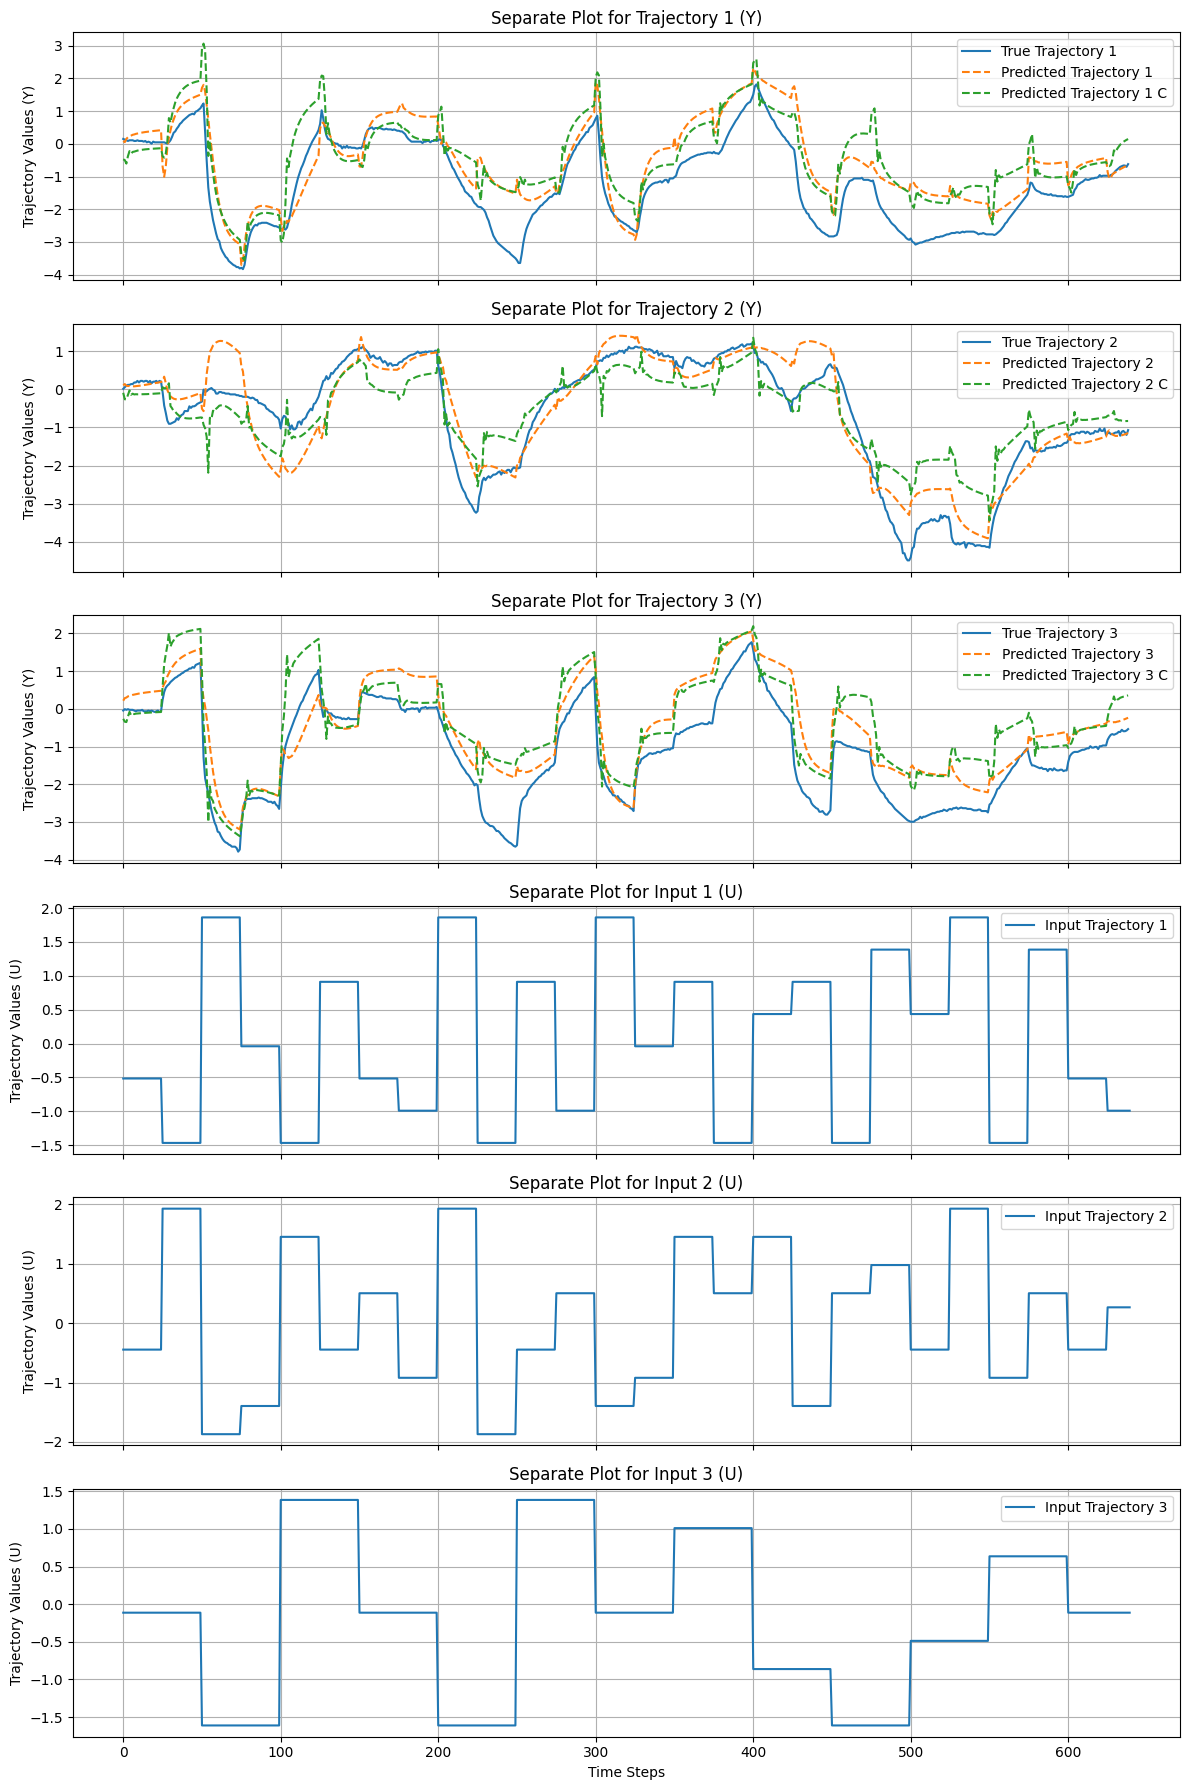

In [ ]:
fig, axs = plt.subplots(ny + nu, 1, figsize=(12, 3 * (ny + nu)), sharex=True)

# Separate plots for each vector in Y
for i in range(ny):
    axs[i].plot(true_traj[i], label=f'True Trajectory {i + 1}', linestyle='-')
    axs[i].plot(pred_traj[i], label=f'Predicted Trajectory {i + 1}', linestyle='--')
    axs[i].plot(pred_traj_C[i], label=f'Predicted Trajectory {i + 1} C', linestyle='--')
    #axs[i].plot(pred_traj_J[i], label=f'Predicted Trajectory {i + 1} J', linestyle='--')
    axs[i].set_title(f'Separate Plot for Trajectory {i + 1} (Y)')
    axs[i].legend()
    axs[i].grid()

# Separate plots for each vector in U
for i in range(nu):
    axs[ny + i].plot(input_traj[i], label=f'Input Trajectory {i + 1}', linestyle='-')
    axs[ny + i].set_title(f'Separate Plot for Input {i + 1} (U)')
    axs[ny + i].legend()
    axs[ny + i].grid()

# Add labels
axs[-1].set_xlabel('Time Steps')
for i in range(ny):
    axs[i].set_ylabel('Trajectory Values (Y)')
for i in range(nu):
    axs[ny + i].set_ylabel('Trajectory Values (U)')

plt.tight_layout()
plt.show()


In [ ]:
# calculate MAE of predicted trajectories
mae_pred = np.mean(np.abs(true_traj[:, :] - pred_traj[:, :]), axis=1)
mae_pred_C = np.mean(np.abs(true_traj[:, :] - pred_traj_C[:, :]), axis=1)
mae_pred_J = np.mean(np.abs(true_traj[:, :] - pred_traj_J[:, :]), axis=1)
print(f'MAE of predicted trajectory: {sum(mae_pred)}')
print(f'MAE of predicted trajectory C: {sum(mae_pred_C)}')
print(f'MAE of predicted trajectory J: {sum(mae_pred_J)}')

MAE of predicted trajectory: 1.9485573768615723
MAE of predicted trajectory C: 2.2482526302337646
MAE of predicted trajectory J: 3.1637415036172554


In [ ]:
# Calculate variance of mismatch (error) between test data and predicted data
var_error_pred = np.var(true_traj - pred_traj, axis=1)
var_error_pred_C = np.var(true_traj - pred_traj_C, axis=1)
var_error_pred_J = np.var(true_traj - pred_traj_J, axis=1)

print(f'Variance of mismatch (True - Predicted): {var_error_pred}')
print(f'Variance of mismatch (True - Predicted C): {var_error_pred_C}')
print(f'Variance of mismatch (True - Predicted J): {var_error_pred_J}')



Variance of mismatch (True - Predicted): [0.35853368 0.39249742 0.27216917]
Variance of mismatch (True - Predicted C): [0.3670434  0.59864336 0.25935915]
Variance of mismatch (True - Predicted J): [1.20834941 0.72878089 0.47370394]


In [ ]:
# Calculate mean squared error (MSE) of all test predictions
mse_pred = np.mean((true_traj - pred_traj) ** 2)
mse_pred_C = np.mean((true_traj - pred_traj_C) ** 2)
mse_pred_J = np.mean((true_traj - pred_traj_J) ** 2)

print(f'MSE of predicted trajectory: {mse_pred}')
print(f'MSE of predicted trajectory C: {mse_pred_C}')
print(f'MSE of predicted trajectory J: {mse_pred_J}')


MSE of predicted trajectory: 0.6343302130699158
MSE of predicted trajectory C: 0.7959882616996765
MSE of predicted trajectory J: 1.803238458160413


In [ ]:
# Define lower and upper bounds for true_traj values
lower_bound = -0.50
upper_bound = 0.50

# Create mask for values within the specified range
mask = (true_traj >= lower_bound) & (true_traj <= upper_bound)

# Compute MAE only for masked values
mae_pred_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_C_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_C[i][mask[i]])) for i in range(true_traj.shape[0])]
mae_pred_J_masked = [np.mean(np.abs(true_traj[i][mask[i]] - pred_traj_J[i][mask[i]])) for i in range(true_traj.shape[0])]

print(f'Masked MAE of predicted trajectory: {mae_pred_masked}')
print(f'Masked MAE of predicted trajectory C: {mae_pred_C_masked}')
print(f'Masked MAE of predicted trajectory J: {mae_pred_J_masked}')

Masked MAE of predicted trajectory: [np.float32(0.6087683), np.float32(0.6433672), np.float32(0.69366777)]
Masked MAE of predicted trajectory C: [np.float32(0.53284097), np.float32(0.3804272), np.float32(0.5122286)]
Masked MAE of predicted trajectory J: [np.float64(0.6744184208552708), np.float64(0.7042066003556106), np.float64(0.7867660275625502)]


In [ ]:
J_mean

array([[-0.0846417 ,  0.06949001,  0.464764  , -0.3664038 ,  0.29912284,
         0.16393058, -0.10626316, -0.0722108 , -0.43944085, -0.33210534,
         0.67729586,  0.4160709 , -0.6457693 ,  0.05218145, -0.10951839],
       [ 0.13925819,  0.11120844, -0.01630904,  0.02572813, -0.04664058,
        -0.28024605,  0.24513572,  0.30510834, -0.01579964, -0.1080637 ,
         0.01457989,  0.34861192,  0.5031293 , -0.25782204,  0.28433588],
       [ 0.02187174,  0.05769235,  0.00099105, -0.15017603,  0.2028587 ,
        -0.18620266,  0.11726405,  0.05790112, -0.12908457, -0.09769054,
         0.06475492,  0.25413322,  0.03211679, -0.2575817 ,  0.00258831]],
      dtype=float32)

In [ ]:
C

array([[-5.017863  ,  0.75730807, -0.6897665 ,  5.037252  ,  7.451068  ,
         5.411107  ,  8.106914  ,  0.5083493 ,  8.08632   , -2.7392313 ,
         2.3266602 ,  8.430902  , -3.562308  , -0.9913204 ,  2.6084418 ],
       [-7.6609097 , -0.08548337, -1.0500492 ,  5.5309744 , -1.8863968 ,
         4.147872  ,  9.26914   , -0.21860333,  4.9822693 , -6.022167  ,
         2.0473363 , 11.629379  , -2.5171227 , -7.32192   , -1.2667669 ],
       [-6.5062056 ,  0.15518549, -1.2739577 ,  4.9070396 ,  0.9051071 ,
         4.021286  ,  7.8765593 , -0.3629375 ,  4.874864  , -4.661909  ,
         1.3838626 ,  9.794952  , -1.9050337 , -5.105637  , -0.22732829]],
      dtype=float32)

In [ ]:
# mse C-J
mse_C_J = np.mean((C - J_mean) ** 2)
print("Mean Squared Error between C and J_mean:\n", mse_C_J)
# mse C-J
mse_C_J = np.mean((C - J) ** 2)
print("Mean Squared Error between C and J:\n", mse_C_J)

Mean Squared Error between C and J_mean:
 25.073956
Mean Squared Error between C and J:
 24.973742


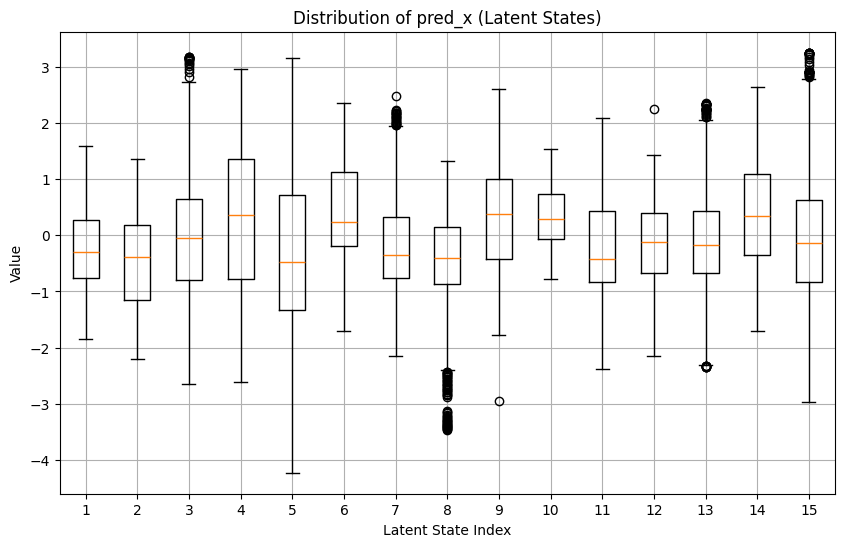

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot(pred_x.T)
plt.title('Distribution of pred_x (Latent States)')
plt.xlabel('Latent State Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

## Open-loop simulation with zero inputs


In [ ]:
# Set up open-loop simulation parameters
n_sim_steps = 500

# Use mean of training data as initial condition (in original scale)
Y0_mean = np.mean(train['Y'], axis=0).reshape(1, 1, ny)

# Scale the initial condition
Y0_scaled = scaler.transform(Y0_mean.reshape(1, -1)).reshape(1, 1, ny)
Y0_tensor = torch.tensor(Y0_scaled, dtype=torch.float32)

# Create zero inputs for all simulation steps (in original scale)
U_scaled = np.zeros((1, n_sim_steps, nu))
U_tensor = torch.tensor(U_scaled, dtype=torch.float32)

# Create dummy Y vector as zeros for all simulation steps
Y_dummy_scaled = np.zeros((1, n_sim_steps, ny))
Y_dummy_tensor = torch.tensor(Y_dummy_scaled, dtype=torch.float32)

# Create simulation data dictionary, adding dummy Y
sim_data = {
    'Y0': Y0_tensor,
    'U': U_tensor,
    'Y': Y_dummy_tensor
}

print(f"Initial condition (scaled): {Y0_scaled.flatten()}")
print(f"Input shape: {U_tensor.shape}")
print(f"Dummy Y shape: {Y_dummy_tensor.shape}")
print(f"Simulation will run for {n_sim_steps} steps")


Initial condition (scaled): [0. 0. 0.]
Input shape: torch.Size([1, 500, 3])
Dummy Y shape: torch.Size([1, 500, 3])
Simulation will run for 500 steps


In [ ]:
# Update the rollout length for simulation
problem.nodes[3].nsteps = n_sim_steps

# Run the open-loop simulation
sim_outputs = problem.step(sim_data)

# Extract predicted outputs
sim_yhat = sim_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny)

# Unscale the outputs to original scale
sim_yhat_unscaled = scaler.inverse_transform(sim_yhat)

# Extract latent states
sim_x = sim_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz)

print(f"Simulation completed!")
print(f"Output shape: {sim_yhat_unscaled.shape}")
print(f"Latent state shape: {sim_x.shape}")


Simulation completed!
Output shape: (499, 3)
Latent state shape: (499, 15)


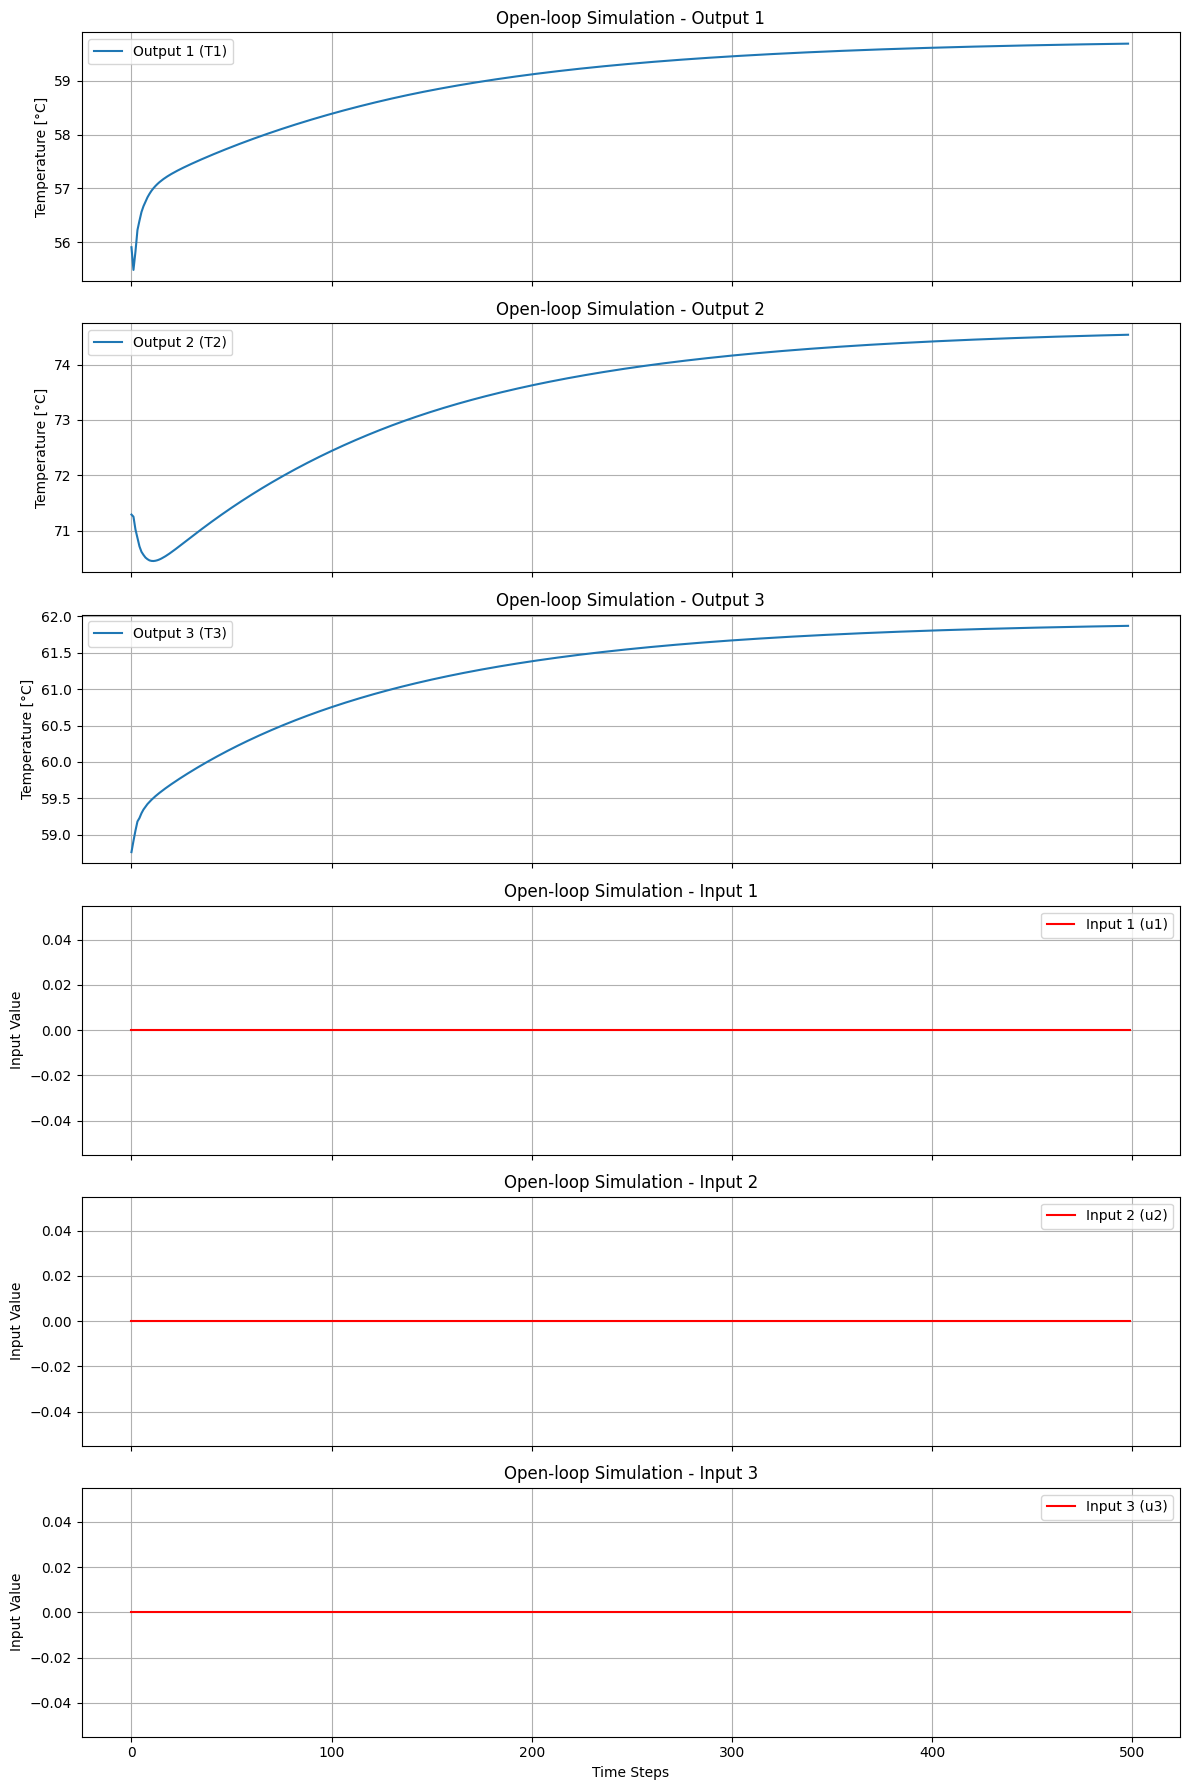


Simulation Statistics:
Final output values: [59.69141  74.53976  61.868248]
Output range: [[55.483463 70.452576 58.763397], [59.69141  74.53976  61.868248]]
Output mean: [58.98985 73.44309 61.26556]
Output std: [0.7856691 1.1719104 0.6734013]


In [ ]:
# Plot the open-loop simulation results
fig, axs = plt.subplots(ny + nu, 1, figsize=(12, 3 * (ny + nu)), sharex=True)

# Plot outputs
for i in range(ny):
    axs[i].plot(sim_yhat_unscaled[:, i], label=f'Output {i + 1} (T{i+1 if i < 3 else i+1})', linewidth=1.5)
    axs[i].set_title(f'Open-loop Simulation - Output {i + 1}')
    axs[i].set_ylabel('Temperature [°C]')
    axs[i].legend()
    axs[i].grid(True)

# Plot inputs (zeros)
for i in range(nu):
    axs[ny + i].plot(U_scaled[0, :, i], label=f'Input {i + 1} (u{i+1})', linewidth=1.5, color='red')
    axs[ny + i].set_title(f'Open-loop Simulation - Input {i + 1}')
    axs[ny + i].set_ylabel('Input Value')
    axs[ny + i].legend()
    axs[ny + i].grid(True)

# Add x-axis label to the last subplot
axs[-1].set_xlabel('Time Steps')

plt.tight_layout()
plt.show()

# Print some statistics
print("\nSimulation Statistics:")
print(f"Final output values: {sim_yhat_unscaled[-1, :]}")
print(f"Output range: [{sim_yhat_unscaled.min(axis=0)}, {sim_yhat_unscaled.max(axis=0)}]")
print(f"Output mean: {sim_yhat_unscaled.mean(axis=0)}")
print(f"Output std: {sim_yhat_unscaled.std(axis=0)}")
